# Get HLS and DSWE

Get some related data

In [32]:
import geopandas as gpd
import os
import rasterio
import rasterio.mask
from pathlib import Path
from rasterio.plot import show
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import pandas as pd
from pystac_client import Client  
from osgeo import gdal
from tqdm import tqdm
import numpy as np
from shapely.geometry import shape

# Parameters

Specify *exactly* one. The `site_name` or the `planet_id`. The former is given to the chip by the validation team. Because we are not selecting multiple planet scenes per chip and not selecting planet images that cover multiple chips (they are sufficiently spaced apart), this should be a 1 to 1 mapping.

In [2]:
PLANET_ID = ''
SITE_NAME = '3_28'

# ^ is exclusive or; makes sure you only specified one
assert((len(PLANET_ID) == 0) ^ (len(SITE_NAME) == 0))

In [3]:
download_dir = Path('planet_images')

# Environment

In [4]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

# Get Image Database

In [5]:
df_images = gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_images.dropna(inplace=True)
df_images.head()

,collocated_dswx,dswx_cloud_cover,datetime,image_name,cloud_cover,site_coverage,instrument,provider,resolution,timeDelta_days,site_name,Strata,geometry
0,HLS.S30.T04WDB.2021271T225541.v2.0,4.0,2021-09-29 21:28:09.168000+00:00,20210929_212809_16_2442,0.0,90.820013,PSB.SD,planetscope,3.0,0.938606,3_38,3.0,"POLYGON ((-160.00896 69.30478, -160.21043 69.1..."
1,HLS.S30.T33WXP.2021270T104719.v2.0,16.0,2021-09-27 09:55:37.877000+00:00,20210927_095537_0f15,0.0,41.216128,PS2,planetscope,3.0,0.039303,4_43,4.0,"POLYGON ((17.22275 66.09223, 17.16459 66.02168..."
2,HLS.L30.T40WFU.2021268T073033.v2.0,2.0,2021-09-25 07:27:12.166000+00:00,20210925_072712_16_2254,0.0,72.272530,PSB.SD,planetscope,3.0,0.002335,3_1,3.0,"POLYGON ((59.00446 65.95517, 58.85023 65.76646..."
3,HLS.S30.T14VPQ.2021244T175911.v2.0,2.0,2021-09-01 17:52:05.712000+00:00,20210901_175205_71_2426,0.0,100.000000,PSB.SD,planetscope,3.0,0.010000,4_34,4.0,"POLYGON ((-96.94381 62.88876, -97.07609 62.707..."
4,HLS.S30.T52VFP.2021253T023549.v2.0,2.0,2021-09-11 00:51:29.821000+00:00,20210911_005129_82_106a,0.0,100.000000,PS2.SD,planetscope,3.0,0.924389,3_30,3.0,"POLYGON ((130.86458 61.50211, 130.95358 61.357..."


In [6]:
temp = df_images[['image_name', 'site_name']]
df_site2image = temp.set_index('site_name')
df_image2site = temp.set_index('image_name')
df_site2image.head()

,image_name
site_name,
3_38,20210929_212809_16_2442
4_43,20210927_095537_0f15
3_1,20210925_072712_16_2254
4_34,20210901_175205_71_2426
3_30,20210911_005129_82_106a


In [7]:
df_site = gpd.read_file('s3://opera-calval-database-dswx/site.geojson')
df_site.dropna(inplace=True)
df_site.head()

,site_name,water_content,geometry
0,3_38,3.0,"POLYGON ((-159.78489 69.25969, -159.65899 69.2..."
1,4_27,4.0,"POLYGON ((-113.10838 67.09964, -113.09840 67.0..."
2,4_43,4.0,"POLYGON ((17.61007 66.01963, 17.81779 66.01970..."
3,3_1,3.0,"POLYGON ((59.55613 65.74045, 59.55651 65.83973..."
4,4_34,4.0,"POLYGON ((-96.71059 62.77966, -96.57702 62.779..."


In [8]:
cols_to_merge = [col for col in df_images.columns if col != 'geometry']
df_temp = df_images[cols_to_merge]
df_chips = pd.merge(df_site, df_temp , on='site_name', how='left')
df_chips.head()

,site_name,water_content,geometry,collocated_dswx,dswx_cloud_cover,datetime,image_name,cloud_cover,site_coverage,instrument,provider,resolution,timeDelta_days,Strata
0,3_38,3.0,"POLYGON ((-159.78489 69.25969, -159.65899 69.2...",HLS.S30.T04WDB.2021271T225541.v2.0,4.0,2021-09-29 21:28:09.168000+00:00,20210929_212809_16_2442,0.0,90.820013,PSB.SD,planetscope,3.0,0.938606,3.0
1,4_27,4.0,"POLYGON ((-113.10838 67.09964, -113.09840 67.0...",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4_43,4.0,"POLYGON ((17.61007 66.01963, 17.81779 66.01970...",HLS.S30.T33WXP.2021270T104719.v2.0,16.0,2021-09-27 09:55:37.877000+00:00,20210927_095537_0f15,0.0,41.216128,PS2,planetscope,3.0,0.039303,4.0
3,3_1,3.0,"POLYGON ((59.55613 65.74045, 59.55651 65.83973...",HLS.L30.T40WFU.2021268T073033.v2.0,2.0,2021-09-25 07:27:12.166000+00:00,20210925_072712_16_2254,0.0,72.272530,PSB.SD,planetscope,3.0,0.002335,3.0
4,4_34,4.0,"POLYGON ((-96.71059 62.77966, -96.57702 62.779...",HLS.S30.T14VPQ.2021244T175911.v2.0,2.0,2021-09-01 17:52:05.712000+00:00,20210901_175205_71_2426,0.0,100.000000,PSB.SD,planetscope,3.0,0.010000,4.0


In [9]:
if not PLANET_ID:
    values = PLANET_ID = df_site2image.loc[SITE_NAME].tolist()
    PLANET_ID = values[0]
    print(f'There was {len(values)} planet images for this chip')
else:
    values = df_image2site.loc[PLANET_ID].tolist()
    SITE_NAME = values[0]
    print(f'There were {len(values)} chips for this planet_image')

(SITE_NAME, PLANET_ID)

There was 1 planet images for this chip


('3_28', '20210906_101112_28_225a')

In [10]:
HLS_ID = df_images[df_images['image_name'] == PLANET_ID]['collocated_dswx'].values[0]
HLS_ID

'HLS.S30.T30TYN.2021248T105621.v2.0'

# Get HLS

In [11]:
HLS_ID = 'HLS.L30.T14RNV.2022003T170902.v2.0'

In [12]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0', 'HLSS30.v2.0']

search_params = {"collections": hls_collections,
                 "ids": HLS_ID}
search_hls = api.search(**search_params)
search_hls

In [13]:
search_hls.matched()


1

In [14]:
hls_collection = list(search_hls.get_all_items())
metadata = hls_collection[0].to_dict()
metadata

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'HLS.L30.T14RNV.2022003T170902.v2.0',
 'properties': {'datetime': '2022-01-03T17:09:02.012000Z',
  'start_datetime': '2022-01-03T17:09:02.012Z',
  'end_datetime': '2022-01-03T17:09:25.903Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-98.3057891, 30.6429651],
    [-98.0325079, 31.6318814],
    [-99.0002109, 31.6355471],
    [-99.0002087, 30.6448187],
    [-98.3057891, 30.6429651]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0/items/HLS.L30.T14RNV.2022003T170902.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'LPCLOUD'},
  {'rel': 'provider', 

# HLS Imagery

First, make sure you have logged into [Earthdata Login](https://urs.earthdata.nasa.gov/) (it will store cookies in ~/cookies.txt). Below, I copied code from this [link](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/) in section 4. It seems to work.

In [15]:
# GDAL configs used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','FALSE')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

In [16]:
urls = [metadata['assets'][band]['href'] for band in ['B02', 'B03', 'B04']]
urls

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B02.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B03.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T14RNV.2022003T170902.v2.0/HLS.L30.T14RNV.2022003T170902.v2.0.B04.tif']

100%|██████████████| 3/3 [01:16<00:00, 25.60s/it]


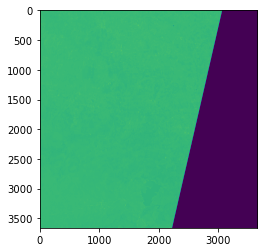

In [17]:
def read_one(url):
    with rasterio.open(url) as ds:
        p = ds.profile
        X = ds.read(1)
    return X, p

images, profiles = zip(*[read_one(url) for url in tqdm(urls)])
plt.imshow(images[0])

# Cloud Mask and Coverage

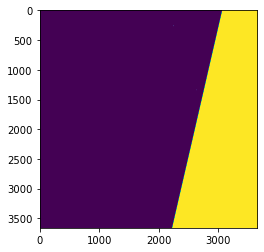

In [24]:
nodata_mask = images[0] == profiles[0]['nodata']
plt.imshow(nodata_mask)

In [25]:
fmask_url = metadata['assets']['Fmask']['href']
metadata_url = metadata['assets']['metadata']['href']

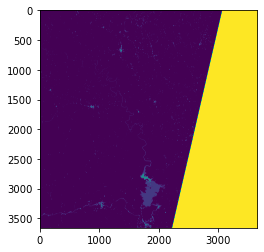

In [26]:
fmask, _ = read_one(fmask_url)

plt.imshow(fmask)

In [27]:
m, n = fmask.shape
fmask_bits = np.unpackbits(fmask)
fmask_bits = fmask_bits.reshape((m, n, 8))
fmask_bits.shape

(3660, 3660, 8)

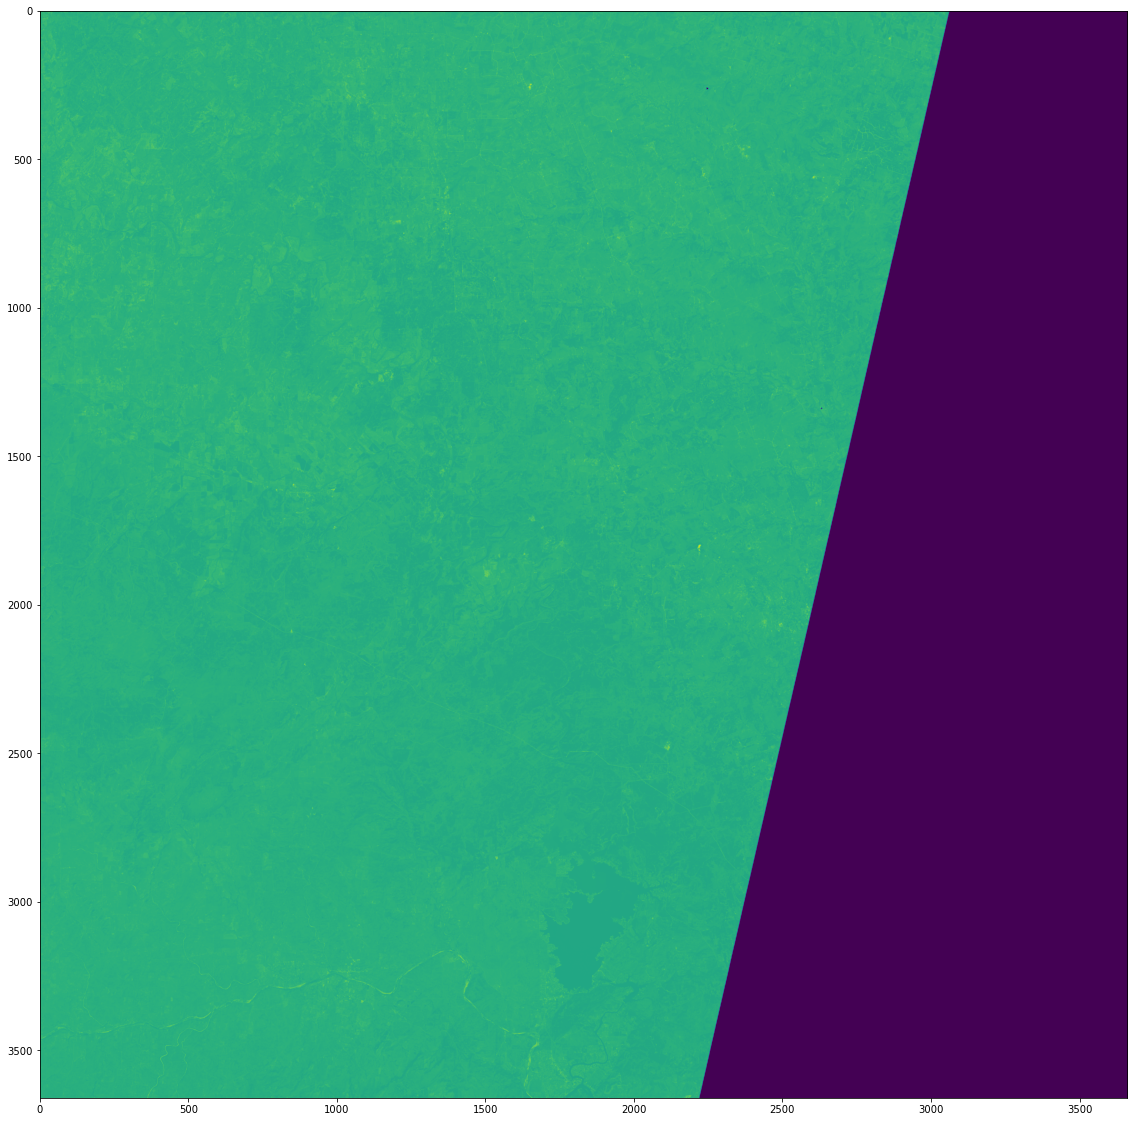

In [31]:
plt.figure(figsize=(20, 20))
plt.imshow(images[2])

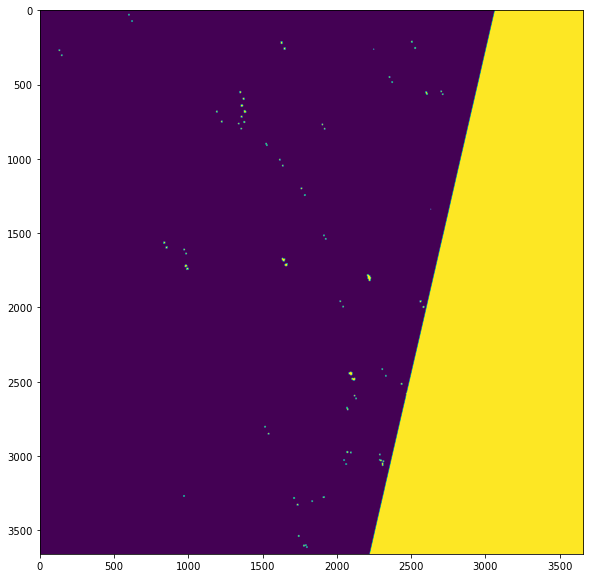

In [29]:
plt.figure(figsize=(10, 10))
fmask_clouds = fmask_bits[..., -2] | fmask_bits[..., -4] 
plt.imshow(fmask_clouds)

In [30]:
percent_clouds = (fmask_clouds[~nodata_mask].sum()) / ((~nodata_mask).sum())
percent_clouds

0.0010154256472535976

In [228]:
def find_attribute_value(metadata_url, attribute):
    metadata_tree = etree.fromstring(requests.get(metadata_url).content)
    atts = metadata_tree.findall('.//AdditionalAttribute')
    values = [att.find('.//Value').text for att in atts if att.find('.//Name').text == attribute]
    if not values:
        raise ValueError('Attribute not found')
    return values[0]

In [229]:
find_attribute_value(metadata_url, 'CLOUD_COVERAGE')

'22'

In [215]:
b.find('.//Name').text

'IDENTIFIER_PRODUCT_DOI_AUTHORITY'

In [223]:
metadata_url

'https://cmr.earthdata.nasa.gov/search/concepts/G2116094319-LPCLOUD.xml'

In [213]:
b.findall('.//Value')[0].text

'https://doi.org'

In [207]:
for b in a:
    print(b.getchildren()[0].text)

PRODUCT_URI
CLOUD_COVERAGE
MGRS_TILE_ID
SPATIAL_COVERAGE
SPATIAL_RESOLUTION
HLS_PROCESSING_TIME
SENSING_TIME
HORIZONTAL_CS_CODE
HORIZONTAL_CS_NAME
ULX
ULY
SPATIAL_RESAMPLING_ALG
ADD_OFFSET
REF_SCALE_FACTOR
ANG_SCALE_FACTOR
FILLVALUE
QA_FILLVALUE
NCOLS
NROWS
MEAN_SUN_AZIMUTH_ANGLE
MEAN_SUN_ZENITH_ANGLE
MEAN_VIEW_AZIMUTH_ANGLE
MEAN_VIEW_ZENITH_ANGLE
NBAR_SOLAR_ZENITH
MSI_BAND_01_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_02_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_03_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_04_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_11_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_12_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
MSI_BAND_8A_BANDPASS_ADJUSTMENT_SLOPE_AND_OFFSET
AROP_AVE_XSHIFT(METERS)
AROP_AVE_YSHIFT(METERS)
AROP_NCP
AROP_RMSE(METERS)
AROP_S2_REFIMG
ACCODE
PROCESSING_BASELINE
IDENTIFIER_PRODUCT_DOI
IDENTIFIER_PRODUCT_DOI_AUTHORITY


In [208]:
from lxml import etree
import requests

import xml.etree.ElementTree as ET


metadata_tree = etree.fromstring(requests.get(metadata_url).content)
a = metadata_tree.findall('.//AdditionalAttribute')
a
#atts = metadata_tree.findall('AdditionalAttributes')
#atts[0].getchildren()[3].getchildren()[1].text

[<Element AdditionalAttribute at 0x1c7d045c0>,
 <Element AdditionalAttribute at 0x1c852f840>,
 <Element AdditionalAttribute at 0x1c852eb00>,
 <Element AdditionalAttribute at 0x1c852d8c0>,
 <Element AdditionalAttribute at 0x1c852d100>,
 <Element AdditionalAttribute at 0x1c852f600>,
 <Element AdditionalAttribute at 0x1c810d840>,
 <Element AdditionalAttribute at 0x1c810c840>,
 <Element AdditionalAttribute at 0x1c810f000>,
 <Element AdditionalAttribute at 0x1c810f9c0>,
 <Element AdditionalAttribute at 0x1c80f6740>,
 <Element AdditionalAttribute at 0x1c810da80>,
 <Element AdditionalAttribute at 0x1c810c600>,
 <Element AdditionalAttribute at 0x1c8109500>,
 <Element AdditionalAttribute at 0x1c8109380>,
 <Element AdditionalAttribute at 0x1c810ab80>,
 <Element AdditionalAttribute at 0x1c810a5c0>,
 <Element AdditionalAttribute at 0x1c8089c00>,
 <Element AdditionalAttribute at 0x1c8088fc0>,
 <Element AdditionalAttribute at 0x1c8089a40>,
 <Element AdditionalAttribute at 0x1c8089e40>,
 <Element Add

In [142]:
atts[0].getchildren()[3].getchildren()[1].tag

'Values'

In [109]:
atts[0].getchildren()[3].keys()

[]

In [95]:
dir(atts[0].getchildren()[0])

['__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init',
 'addnext',
 'addprevious',
 'append',
 'attrib',
 'base',
 'clear',
 'cssselect',
 'extend',
 'find',
 'findall',
 'findtext',
 'get',
 'getchildren',
 'getiterator',
 'getnext',
 'getparent',
 'getprevious',
 'getroottree',
 'index',
 'insert',
 'items',
 'iter',
 'iterancestors',
 'iterchildren',
 'iterdescendants',
 'iterfind',
 'itersiblings',
 'itertext',
 'keys',
 'makeelement',
 'nsmap',
 'prefix',
 'remove',
 'replace',
 'set',
 'sourceline',
 'tag',
 'tail',
 'text',
 'values',
 'xpath']

In [88]:
dir(atts[0])

['__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init',
 'addnext',
 'addprevious',
 'append',
 'attrib',
 'base',
 'clear',
 'cssselect',
 'extend',
 'find',
 'findall',
 'findtext',
 'get',
 'getchildren',
 'getiterator',
 'getnext',
 'getparent',
 'getprevious',
 'getroottree',
 'index',
 'insert',
 'items',
 'iter',
 'iterancestors',
 'iterchildren',
 'iterdescendants',
 'iterfind',
 'itersiblings',
 'itertext',
 'keys',
 'makeelement',
 'nsmap',
 'prefix',
 'remove',
 'replace',
 'set',
 'sourceline',
 'tag',
 'tail',
 'text',
 'values',
 'xpath']

# Save

In [18]:
data_dir = Path(f'data/{PLANET_ID}/')
data_dir.mkdir(exist_ok=True, parents=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


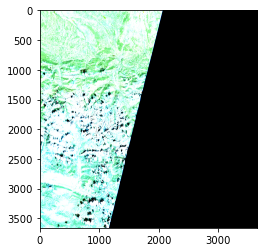

In [19]:
rgb = np.stack(images, axis=2)
plt.imshow(rgb)

In [20]:
p = profiles[0].copy()
p['count'] = 3

with rasterio.open(data_dir/f'rgb_{HLS_ID}.tif', 'w', **p) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

# Visualize Data Boudnaries

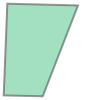

In [21]:
hls_boundary = shape(metadata['geometry'])
hls_boundary

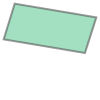

In [22]:
planet_image = df_images[df_images.image_name == PLANET_ID].geometry.values[0]
planet_image

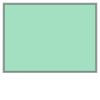

In [23]:
validation_area = df_chips[df_chips.image_name == PLANET_ID].geometry.values[0]
validation_area

In [24]:
df_all = gpd.GeoDataFrame({'extent_label': ['hls', 'planet', 'validation']},
                          geometry=[hls_boundary, planet_image, validation_area],
                          crs=df_chips.crs)

<AxesSubplot:>

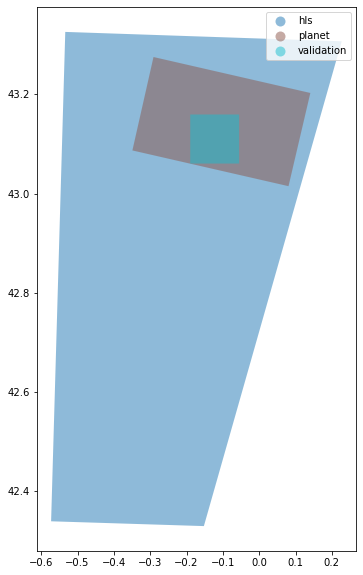

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
df_all.plot(column='extent_label', legend=True, ax=ax, alpha=.5)